# Magnetic and Diagenetic Analyses of Brachfeld et al. (2009)
_____

Paper doi: https://doi.org/10.1016/j.gloplacha.2009.03.023

Core: HLY05-01 JPC5 and TC5, 72.694° N, 157.520° W

Water depth: 415 m

Data in analysis: Magnetite wt. % (from Ms measurements), sedimentation rate, total organic carbon.


In [4]:
# import statements
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines # for legend creation
import numpy as np
import data_fns  # my own module
%matplotlib inline
# plt.rcParams["pdf.fonttype"] = "3" # unnecessary?
plt.rcParams["font.family"] = "Avenir"

Notes: Only the TOC column has non-numbers, so others don't have to get converted to numeric. Using the radiocarbon tie points to calculate sed rate, since I was having problems calculating sed rate from the ages given alongside the Ms measurements. Also, doing sed rate that way would have given values like 15.9999 and 16.00001 when we really just want 16 (as an example).

Formatting issues to deal with:
- Convert columns from "object" to "float"
- Add 75 cm to all Pc depths based on composite depth scale from paper
- Convert TOC depths from intervals to a single depth

In [5]:
# read in data
Pc = pd.read_excel("data/brachfeld2009.xlsx", sheet_name="5JPC")
Tc = pd.read_excel("data/brachfeld2009.xlsx", sheet_name="TC5")
TOC = pd.read_excel("data/brachfeld2009.xlsx", sheet_name="TOC")
tie_points = pd.read_excel("data/brachfeld2009.xlsx", sheet_name="14C")

In [6]:
# Unit adjustments
# divide Pc (corrected) and Tc depths by 100 to get meter units
Pc["Depth [mbsf]"] = Pc["Depth_Corrected (cm-cd)"] / 100
Tc["Depth [mbsf]"] = Tc["Depth_cm"] / 100
# divide Pc and Tc Ms measurements by 92 to get magnetite mass fraction
# multiply by 10^6 to get from mass fraction to ppm
Pc["Magnetite [ppm]"] = (Pc["Ms_Am2/kg"] * 10**6) / 92
Tc["Magnetite [ppm]"] = (Tc["Ms_Am2/kg"] * 10**6) / 92

# divide tie_point ages by 1000000
tie_points["Age [Ma]"] = tie_points["Calib.Age YrBP"] / 1000000

# We are going to treat the Tc and Pc as all one core, so append them together
# not sorting by depth (will do that later)
# do need to ignore index so that each row has a unique index
Pc_Tc = Pc.append(Tc, ignore_index=True)

In [7]:
# Calculate TOC depths
# function to parse TOC depths as midpoint of each interval
def TOC_formatting():
    depths = []
    for i in range(len(TOC["Uncorrected Depth (cm)"])):
        nums = TOC["Uncorrected Depth (cm)"][i].split("-")
        # some intervals are separated by "--" instead of "-", so just grab
        # first and last item of nums, which will definitely be the endpoints
        midpoint = (float(nums[0]) + float(nums[-1])) / 2
        # check if this from Pc, add 75cm if necessary
        if TOC["Core"][i] == "Pc":
            midpoint += 75
        midpoint /= 100 # convert to meters
        depths.append(midpoint)
    return depths
TOC_depths = TOC_formatting()  # hold onto this for later
# semi-related task: convert TOC values to numeric, coercing "na" to np.nan
TOC["TOC [wt. %]"] = pd.to_numeric(TOC["C_org (wt.%)"], errors="coerce")

# Calculate sedimentation rates (see data_fns.py for code details)
sed_rates = data_fns.sed_rates(tie_points["Age [Ma]"], tie_points["Depth_mcd"])

In [8]:
# create DFs of the relevant columns, then can append it all together
magn_df = pd.DataFrame({"Depth [mbsf]":Pc_Tc["Depth [mbsf]"], "Magnetite [ppm]":Pc_Tc["Magnetite [ppm]"]})
TOC_df = pd.DataFrame({"Depth [mbsf]":TOC_depths, "TOC [wt. %]":TOC["TOC [wt. %]"]})
sed_df = pd.DataFrame({"Depth [mbsf]":tie_points["Depth_mcd"], "Sedimentation Rate [m/Myr]":sed_rates})


# appending
comb_df = magn_df.append(TOC_df).append(sed_df).sort_values(by="Depth [mbsf]").reset_index(drop=True)

In [9]:
# next, interpolate the geochem and sed rate data to match up w/magnetite
# sed rate is interpolated even though we don't explicitly mention it
# see data_fns.py for code details
interpolated = data_fns.interpolate(comb_df, ["TOC [wt. %]"])

# can plot the interpolated data (TOC, sed rate) against the original data
# if you want to check interpolation correctness.
# (omitted here for brevity)

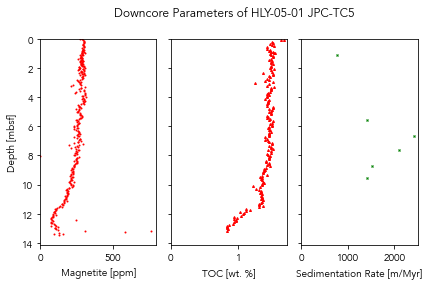

In [10]:
# downcore plots (see data_fns.py for code details)
colors = ["r", "r", "g"]
markers = [".", "^", "x"]
dc_fig, dc_axs = data_fns.plot_dc(["Magnetite [ppm]", "TOC [wt. %]", "Sedimentation Rate [m/Myr]"], comb_df, colors, markers)
dc_fig.suptitle("Downcore Parameters of HLY-05-01 JPC-TC5", x=0.55)
dc_fig.tight_layout()
dc_fig.savefig("outputs/brachfeld2009/jpc5_dc1-aug23.pdf")

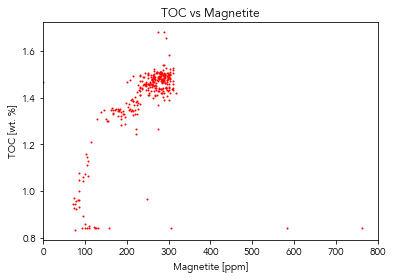

In [11]:
# comparison plots
comp_figs, comp_axs = data_fns.plot_comp(["TOC [wt. %]"], interpolated, ["r"], ["."])

comp_axs[0].set(xlabel="Magnetite [ppm]", ylabel="TOC [wt. %]", title="TOC vs Magnetite")
comp_axs[0].set_xlim(xmin=0)

# saving figures
comp_figs[0].savefig("outputs/brachfeld2009/comp_TOC.pdf")

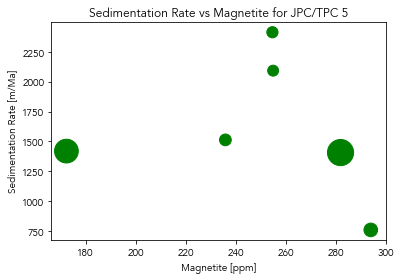

In [10]:
# sed rates comp plot
sed_fig, sed_ax, sed_sc = data_fns.sed_avg_plot(interpolated, 6)
sed_ax.set(xlabel="Magnetite [ppm]", ylabel="Sedimentation Rate [m/Myr]", title = "Sedimentation Rate vs Magnetite for JPC/TPC 5")
sed_fig.savefig("outputs/brachfeld2009/brachfeld2009_sed-comp.pdf")

In [15]:
# compile results and add to compilation excel doc
data_fns.write_output(interpolated, "HLY05-01 JPC-TC5", "data/comp_inter.xlsx")
data_fns.write_output(comb_df, "HLY05-01 JPC-TC5", "data/comp_raw.xlsx")